[https://www.tensorflow.org/tutorials/structured_data/time_series]

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections:

Forecast for a single time step:
- A single feature.
- All features.

Forecast multiple steps:
- Single-shot: Make the predictions all at once.
- Autoregressive: Make one prediction at a time and feed the output back to the model.

- ??? Time-series forecasting require data to be stationary?

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2025-04-07 19:49:52.361990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Dataset datainfo: https://www.kaggle.com/datasets/mnassrib/jena-climate
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)

In [4]:
print(df.columns)
df.head()

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


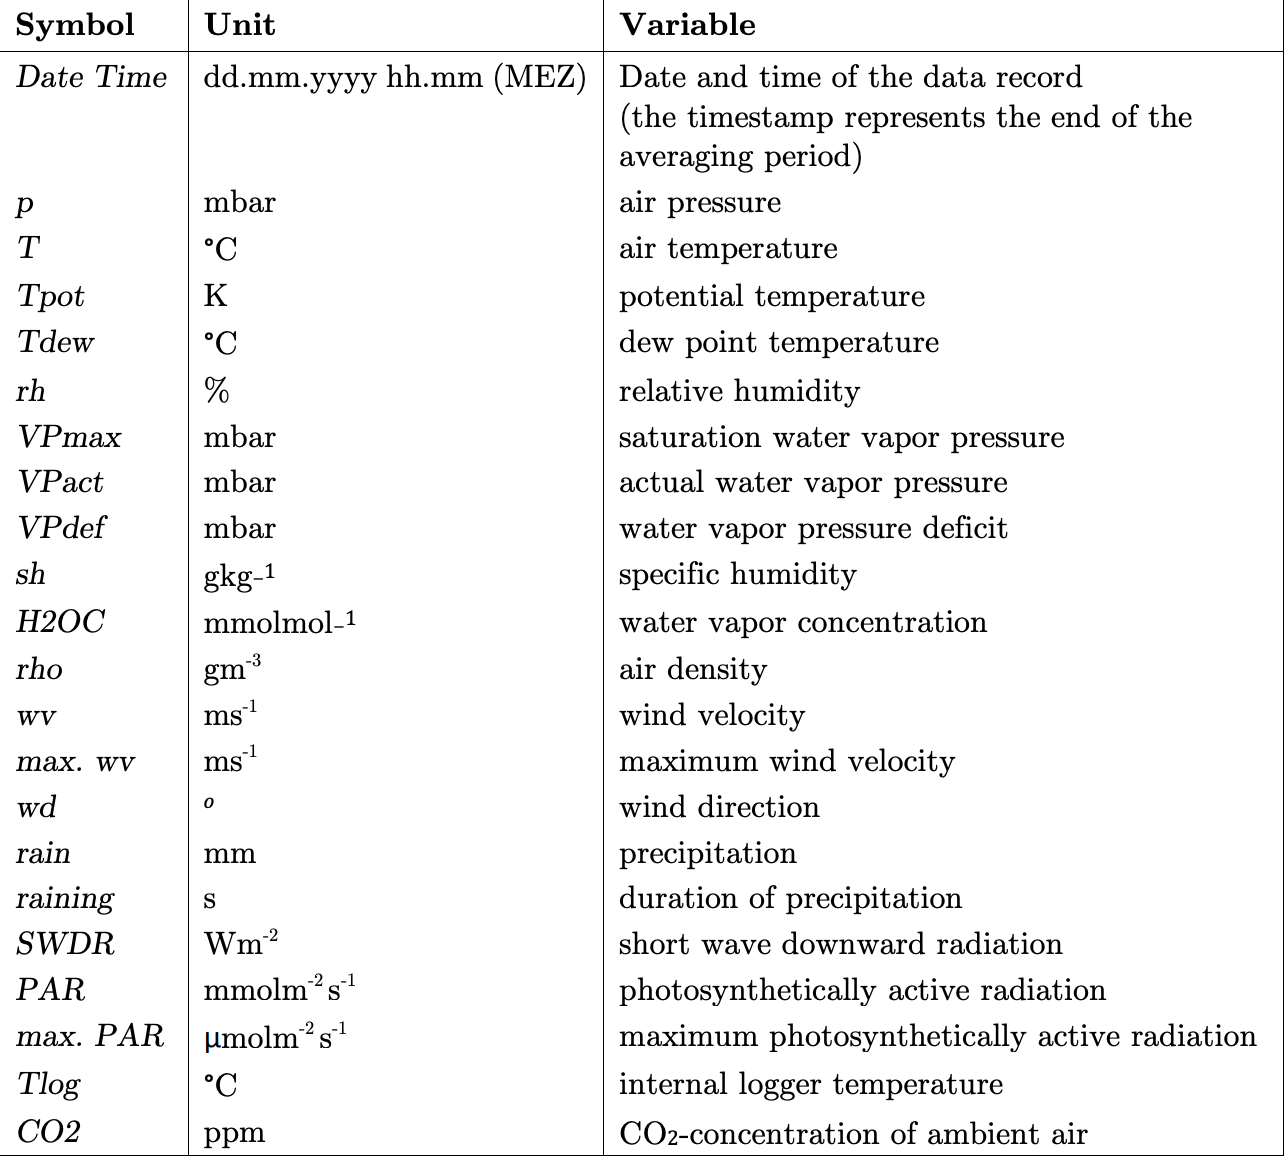

In [5]:
# Slice [start:stop:step], starting from index 5 take every 6th record.
 # To get hourly predictions
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
print(df.shape)
df.head()

(70091, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [7]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

In [8]:
# Wind direction and speed into one wind vector
wv = df.pop("wv (m/s)")
max_wv = df.pop('max. wv (m/s)')

# deg -> radians. rad = deg*pi / 180
 ## It is defined such that one radian is the angle subtended at the
 ## centre of a circle by an arc that is equal in length to the radius.
wd_rad = df.pop('wd (deg)')*np.pi / 180

df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

df['Max Wx'] = max_wv*np.cos(wd_rad)
df['Max Wy'] = max_wv*np.sin(wd_rad)

In [9]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [10]:
"""
Similar to the wind direction, the time in seconds is not a useful model input.
Being weather data, it has clear daily and yearly periodicity.
There are many ways you could deal with periodicity.

Cyclic encoding interpretation: https://www.kaggle.com/discussions/general/491296

sine/cos transformation: sin(2pi*x / cycle_length), cos(2pi*x / cycle_length) 
1. Transform to radians: Radian value = 2pi*x / cycle_length
2. Apply Sine/cos
"""
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

You can determine which frequencies are important by extracting features with ???Fast Fourier Transform

---

### Fast Fourier Transform

----

In [ ]:
df

In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [12]:
train_df.head(3)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,Max Wx,Max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934


In [13]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [14]:
train_df.head(3)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,Max Wx,Max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366111,1.366069,-0.061052,1.428434
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707200,1.224794,-0.060029,1.428424
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000100,1.000059,-0.059006,1.428412


In [15]:
train_df.shape

(49063, 19)

Creating data windows
- Depending on task and type of models, generate a variety of data windows.

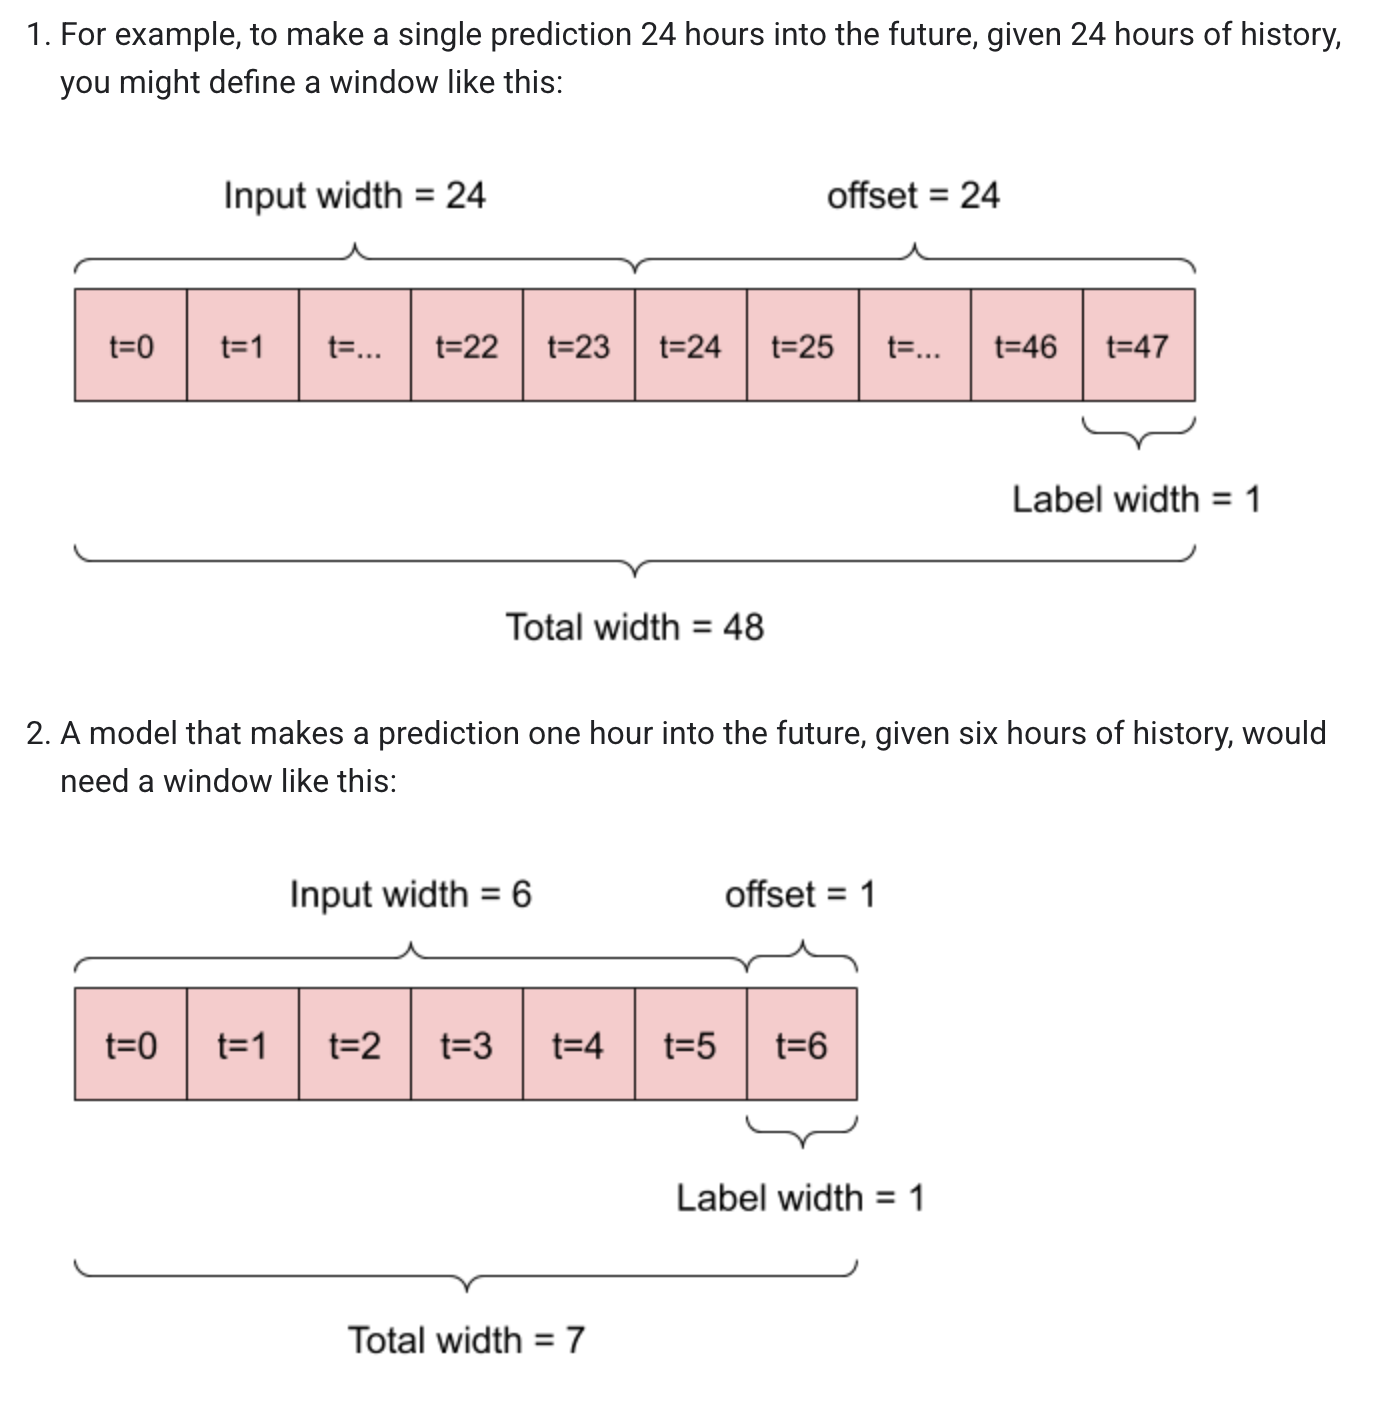

In [16]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        """

        parameters
        ---------
        shift: , ???
        label_columns: list
        """
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name:i for i, name in
                                         enumerate(label_columns)}
        self.column_indices = {name:i for i, name in enumerate(train_df.columns)}

        # Window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        # slice function -> retrieves [:input_width]
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

In [17]:
def split_window(self, features):
    """
    Given a list of consecutive inputs, convert them to a window of 
    inputs and a window of labels.
    """
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] 
             for name in self.label_columns], axis=-1)
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels

WindowGenerator.split_window = split_window

Why would you attach method dynammically? (ft. WindowGenerator.make_dataset = make_dataset)

This is a form of monkey patching — adding methods to a class after it's defined.
Reasons might include:
- Organizing code outside of class body.
- Adding utility functions dynamically.
- For modularity (e.g., separate make_dataset for reuse or testing).
- Working in notebooks where redefining a class cell doesn’t override an old class definition cleanly.

It works, but it’s not recommended for larger or production projects. It’s better to define the function within the class body so it’s easier to read and debug.

In [18]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [19]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [30]:
"""
??? Why 100 step gap between slices? why not stack three consecutive slices? 
"""
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])
example_window

In [22]:
example_inputs, example_labels = w2.split_window(example_window)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


In [23]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32)
    ds = ds.map(self.split_window)
    return ds
WindowGenerator.make_dataset = make_dataset

In [60]:
ds = tf.keras.utils.timeseries_dataset_from_array(
    data=single_step_window.train_df,
    targets=None,
    sequence_length=2,
    sequence_stride=1,
    shuffle=False,
    batch_size=32)

In [24]:
## Decorators
"""
- Allow us to add new functionality to an existing function w.o. modifying it.
- 


*Tips
In Python, by convention, when you add a leading underscore to a name, you are
telling other developers that it should not be accessed or modified
directly outside of the class
It should only be accessed through intermediaries (getters and setters)
if they are available.
 
- ex: self._price
"""


'\n- Allow us to add new functionality to an existing function w.o. modifying it.\n- \n\n\n*Tips\nIn Python, by convention, when you add a leading underscore to a name, you are\ntelling other developers that it should not be accessed or modified\ndirectly outside of the class\nIt should only be accessed through intermediaries (getters and setters)\nif they are available.\n \n- ex: self._price\n'

In [25]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [26]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

# Single time step

In [ ]:
### Keras recap

# Three ways to define a model:

# 1. Sequential API
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

# 2. Functional API
inputs = tf.keras.Input(shape=(None,))
outputs = tf.keras.layers.Dense(units=1)(inputs)
linear = tf.keras.Model(inputs=inputs, outputs=outputs)

# 3. Subclass tf.keras.Model
class LinearModel(tf.keras.Model):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.dense = tf.keras.layers.Dense(units=1)

    def call(self, inputs):
        # Forward pass explicitly coded in call()
        return self.dense(inputs)

linear = LinearModel()

In [27]:
MAX_EPOCHS = 20
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [28]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [ ]:
single_step_window.train

In [31]:
single_step_window.train_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,Max Wx,Max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366111,1.366069,-0.061052,1.428434
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707200,1.224794,-0.060029,1.428424
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000100,1.000059,-0.059006,1.428412
23,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.224850,0.707179,-0.057983,1.428400
29,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.366133,0.366112,-0.056960,1.428388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294353,0.169167,0.904892,0.886564,1.571997,0.947972,0.776492,1.984916,-0.493604,1.979016,1.977352,-0.882480,-0.166720,-1.508412,-0.155728,-1.363530,-0.955374,1.042725,-0.855026,-1.154613
294359,0.266787,0.879473,0.853325,1.405624,0.621793,0.742703,1.680752,-0.283962,1.672043,1.672192,-0.822662,-0.824901,-0.641039,-0.704391,-0.475387,-0.652949,1.254471,-0.855883,-1.154062
294365,0.217374,0.740824,0.719224,1.425703,1.086900,0.559461,1.716396,-0.605690,1.709479,1.707403,-0.716211,-0.030746,0.645277,0.013960,0.600050,-0.306022,1.380734,-0.856739,-1.153511
294371,0.213759,0.710783,0.689423,1.412795,1.147303,0.521772,1.692633,-0.645127,1.687018,1.683929,-0.689842,0.014300,-0.102616,-0.095117,-0.198426,0.061765,1.412909,-0.857595,-1.152959


## Linear model

In [62]:
linear_model = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

In [63]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear_model(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [64]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [65]:
val_performance = {}
performance = {}
# why 1534 rows in training -> train method gets called which create batches of 32.
history = compile_and_fit(linear_model, single_step_window)

val_performance['Linear'] = linear_model.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear_model.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.9982 - mean_absolute_error: 0.6486 - val_loss: 0.0266 - val_mean_absolute_error: 0.1254
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0295 - mean_absolute_error: 0.1245 - val_loss: 0.0122 - val_mean_absolute_error: 0.0820
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0119 - mean_absolute_error: 0.0809 - val_loss: 0.0092 - val_mean_absolute_error: 0.0697
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0092 - mean_absolute_error: 0.0702 - val_loss: 0.0088 - val_mean_absolute_error: 0.0682
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0089 - mean_absolute_error: 0.0692 - val_loss: 0.0088 - val_mean_absolute_error: 0.0685
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0089 - mean_absolute_error: 0.0691 - val_loss: 0.0090 - val_mean_absolute_error: 0.0693
439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0090 - mean_absolute_error: 0.0690


In [66]:
performance

{'Linear': {'loss': 0.008885451592504978,
  'mean_absolute_error': 0.0683538094162941}}

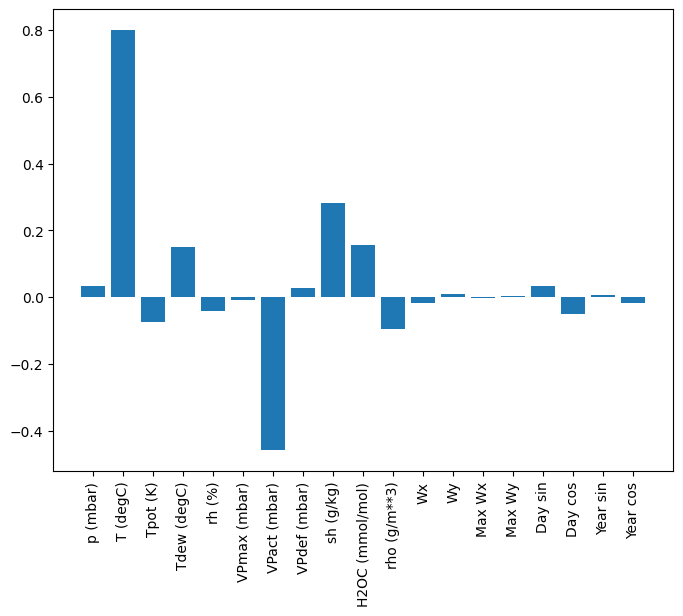

In [67]:
# One advantage to linear models is that they're relatively simple to interpret
# You can pull out the layer's weights and visualize the weight assigned 
# to each input:
plt.bar(x = range(len(train_df.columns)),
        height=linear_model.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense model

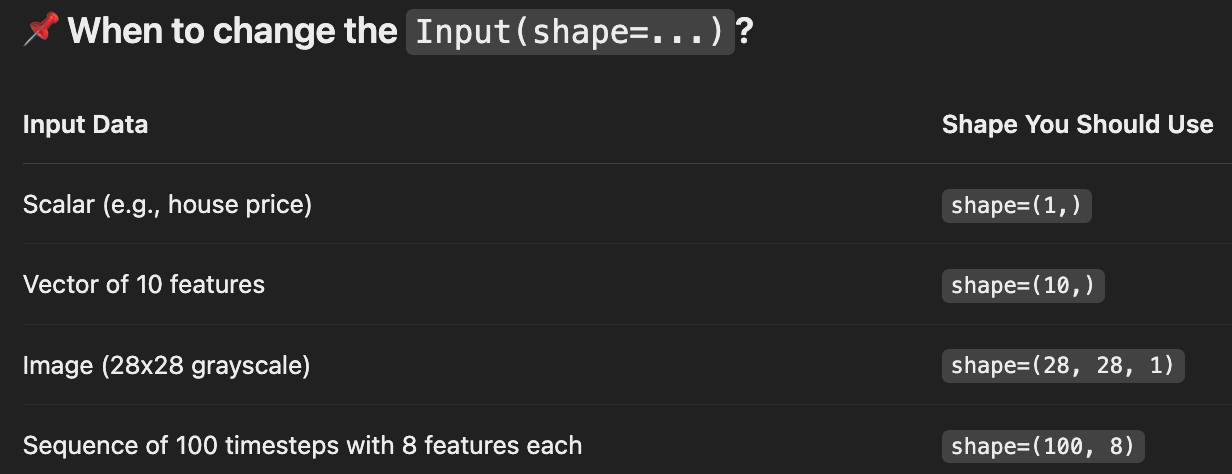

In [68]:
inputs = tf.keras.Input(shape=(None, 19))
dense_1 = tf.keras.layers.Dense(units=64, activation='relu')(inputs)
dense_2 = tf.keras.layers.Dense(units=64, activation='relu')(dense_1)
outputs = tf.keras.layers.Dense(units=1)(dense_2)
dense = tf.keras.Model(inputs=inputs, outputs=outputs)

In [69]:
history = compile_and_fit(dense, single_step_window)

Epoch 1/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0424 - mean_absolute_error: 0.1147 - val_loss: 0.0080 - val_mean_absolute_error: 0.0661
Epoch 2/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0659 - val_loss: 0.0077 - val_mean_absolute_error: 0.0645
Epoch 3/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0078 - mean_absolute_error: 0.0638 - val_loss: 0.0068 - val_mean_absolute_error: 0.0593
Epoch 4/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0073 - mean_absolute_error: 0.0611 - val_loss: 0.0068 - val_mean_absolute_error: 0.0591
Epoch 5/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0071 - mean_absolute_error: 0.0599 - val_loss: 0.0070 - val_mean_absolute_error: 0.0606
Epoch 6/20
1534/1534 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0070 - mean_absolute_error: 0.0596 - val_loss: 0.0076 - val_mean_absolute_error: 0.0625


In [70]:
val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076 - mean_absolute_error: 0.0625


In [71]:
performance

{'Linear': {'loss': 0.008885451592504978,
  'mean_absolute_error': 0.0683538094162941},
 'Dense': {'loss': 0.008147475309669971,
  'mean_absolute_error': 0.06590789556503296}}

# Multi time step
- Single-shot: Make the predictions all at once.
- Autoregressive: Make one prediction at a time and feed the output back to the model.

In [72]:
# Generator that takes three-intervals as input and outputs one interval label
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1, #relative to end of two windows
    label_columns=['T (degC)']
)
conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

In [ ]:
"""
tf.keras.layers.Flatten()
- Reshapes a multi-D tensor into a 1D tensor w/o affecting the batch size
- It's used to reshape 3D data to feed into dense layers when you don’t care
  about sequential ordering anymore.
- ex: If your input shape is (batch_size, timesteps, features), 
      it becomes (batch_size, timesteps * features) after flattening
- It’s typically used when transitioning from sequence or spatial data 
  (like time series or image features) into a fully connected (dense) layer.
   Dense layers require 2D input: (batch_size, features). If you feed them 3D tensors 
   (like what comes from RNNs, Conv1D/2D, etc.), you'll get a shape mismatch error
   unless you flatten or pool first.
"""

## Dense model

In [79]:
# You could train a dense model on a multiple-input-step window by adding a 
# tf.keras.layers.Flatten as the first layer of the model:
inputs = tf.keras.Input(shape=(3, 19))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(units=32, activation='relu')(x)
x = tf.keras.layers.Dense(units=32, activation='relu')(x)
x = tf.keras.layers.Dense(units=1)(x)
outputs = tf.keras.layers.Reshape([1, -1])(x)
multi_step_dense = tf.keras.Model(inputs=inputs, outputs=outputs)

In [80]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [81]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0061 - mean_absolute_error: 0.0548


The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape.

The convolutional models fix this problem. -> ??? Only when using sequential API?

## CNN

??? How exactly does CNN work on images and time series?

In [86]:
# CNN version of multi_step_dense model above.
# 1. Define the input shape (you need to specify the time and feature dimensions)
input_layer = tf.keras.layers.Input(shape=(3, 19))
x = tf.keras.layers.Conv1D(filters=32, kernel_size=(CONV_WIDTH,), activation='relu')(input_layer)
x = tf.keras.layers.Dense(units=32, activation='relu')(x)
# Final dense layer to produce a single output per time step
output_layer = tf.keras.layers.Dense(units=1)(x)
conv_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [91]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


`conv_model` can be run on inputs of any lengths as it is applied to a sliding windows of inputs. => wider input => wider output.

In [95]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0658


## RNN

An important constructor argument for all Keras RNN layers is `return_sequences` argument.
It configure the layer in one of two ways:
1. False, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction.
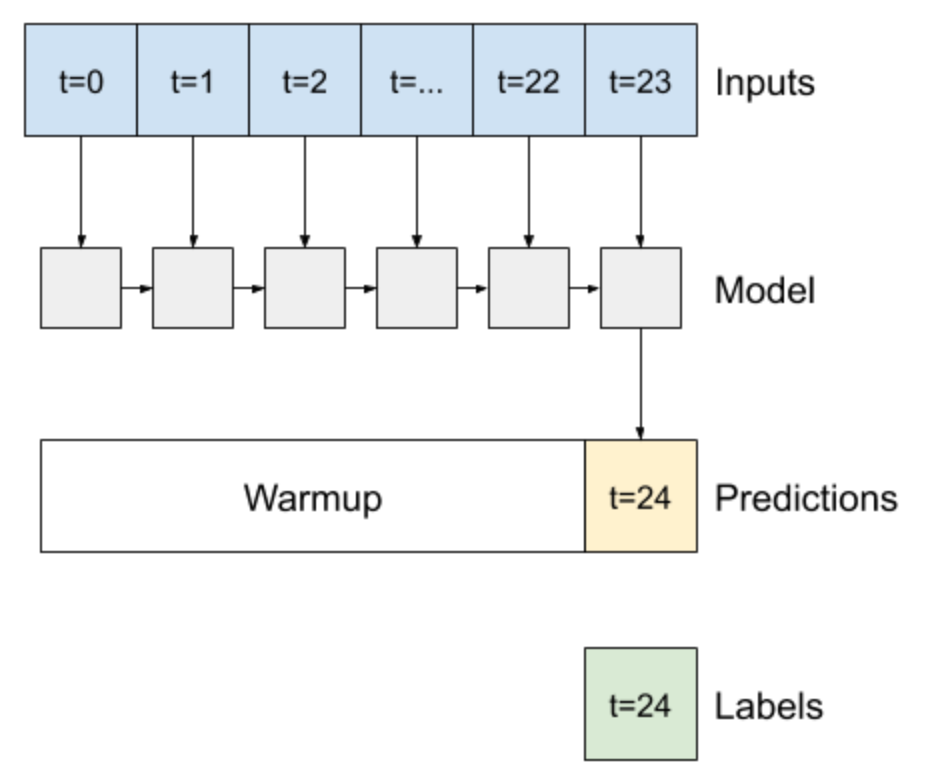

3. True, returns output for each input. Useful for stacking RNN layers and training a model on multiple time steps simultaneously.
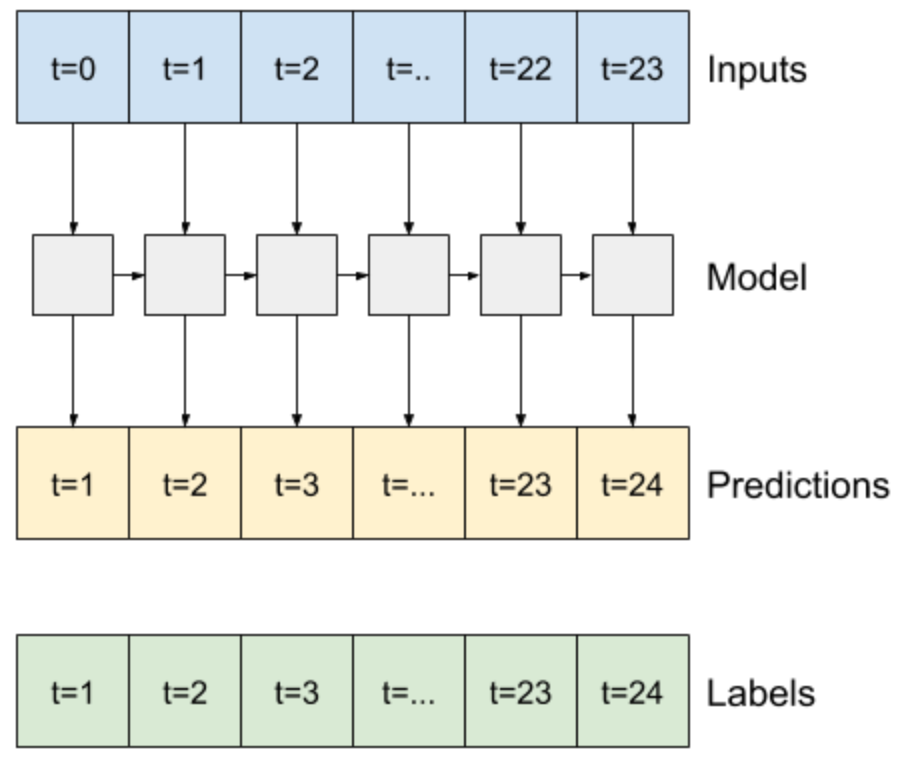

In [96]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [97]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0056 - mean_absolute_error: 0.0520


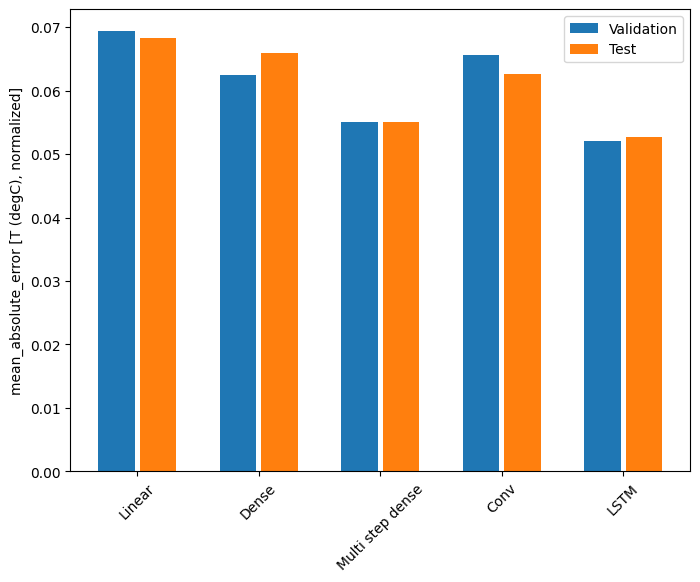

In [100]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

## Multi-output models

Models so far all predicted a single output feature, `T (degC)`.

All of these models can be converted to predict multiple features just by `changing the number of units in the output layer` and `adjusting the training windows to include all features in the labels` (example_labels):

In [102]:
"""
All of these models can be converted to predict multiple features just by changing
the number of units in the output layer and adjusting the training windows to include
all features in the labels (example_labels):
"""
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


2025-04-07 23:35:10.514393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [103]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0, return_dict=True)

print()

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0616 - mean_absolute_error: 0.1203

CPU times: user 9min 59s, sys: 2min 12s, total: 12min 11s
Wall time: 3min 58s


In [ ]:
lstm_model.summary()

Advanced: Residual connections